In [37]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn import set_config

# Load the training and testing data


train_data = pd.read_excel("merged_data_final_training.xlsx")
test_data = pd.read_excel("merged_data_final_testing.xlsx")

# Define categorical and numerical columns
categorical_columns = ['bank_account_type', 'bank_name_clients', 'employment_status_clients', 'level_of_education_clients']
numerical_columns = ['loannumber', 'loanamount', 'totaldue', 'termdays', 'average_loannumber', 'average_loanamount', 'on_time_rate', 'referred_or_not', 'age']

# One-hot encode the categorical variables and normalize the numerical variables
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(), categorical_columns)
    ])
train_data_with_dummies = pd.get_dummies(train_data, columns=categorical_columns)

# Fill missing values for categorical columns with 'Unknown'
for col in categorical_columns:
    train_data[col].fillna('Unknown', inplace=True)
    test_data[col].fillna('Unknown', inplace=True)

# Fill missing values for numerical columns with the median
for col in numerical_columns:
    train_data[col].fillna(train_data[col].median(), inplace=True)
    test_data[col].fillna(test_data[col].median(), inplace=True)

# Separate features and target variable in training data
X_train = train_data.drop(columns=['customerid', 'good_bad_flag'])
y_train = train_data['good_bad_flag'].map({'Good': 1, 'Bad': 0})

# Separate features in test data (excluding 'customerid')
X_test = test_data.drop(columns=['customerid'])


# Define the preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ])


# Fit the preprocessor on the training data
preprocessor.fit(X_train)

train_data.head()



,customerid,loannumber,loanamount,totaldue,termdays,good_bad_flag,bank_account_type,bank_name_clients,employment_status_clients,level_of_education_clients,average_loannumber,average_loanamount,on_time_rate,referred_or_not,age
0,8a2a81a74ce8c05d014cfb32a0da1049,12,30000,34500.0,30,Good,Other,Diamond Bank,Permanent,Post-Graduate,6.0,18181.818182,0.636364,0,52
1,8a8588f35438fe12015444567666018e,7,20000,22250.0,15,Good,Other,EcoBank,Permanent,Unknown,3.5,10000.000000,0.500000,0,39
2,8a85890754145ace015429211b513e16,3,10000,11500.0,15,Good,Savings,First Bank,Permanent,Unknown,1.5,10000.000000,0.000000,0,46
3,8a858970548359cc0154883481981866,9,40000,44000.0,30,Good,Other,GT Bank,Permanent,Primary,4.5,18750.000000,1.000000,0,37
4,8a858e095c59b91b015c5e5cea3719bc,3,10000,13000.0,30,Good,Savings,GT Bank,Permanent,Unknown,1.5,10000.000000,1.000000,0,35


In [41]:
# List of categorical columns
categorical_features = ['bank_account_type', 'bank_name_clients', 'employment_status_clients', 'level_of_education_clients', 'referred_or_not']

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

# Create and fit the pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', DecisionTreeClassifier(random_state=42))])

clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['bank_account_type',
                                                   'bank_name_clients',
                                                   'employment_status_clients',
                                                   'level_of_education_clients',
                                                   'referred_or_not'])])),
                ('classifier', DecisionTreeClassifier(random_state=42))])

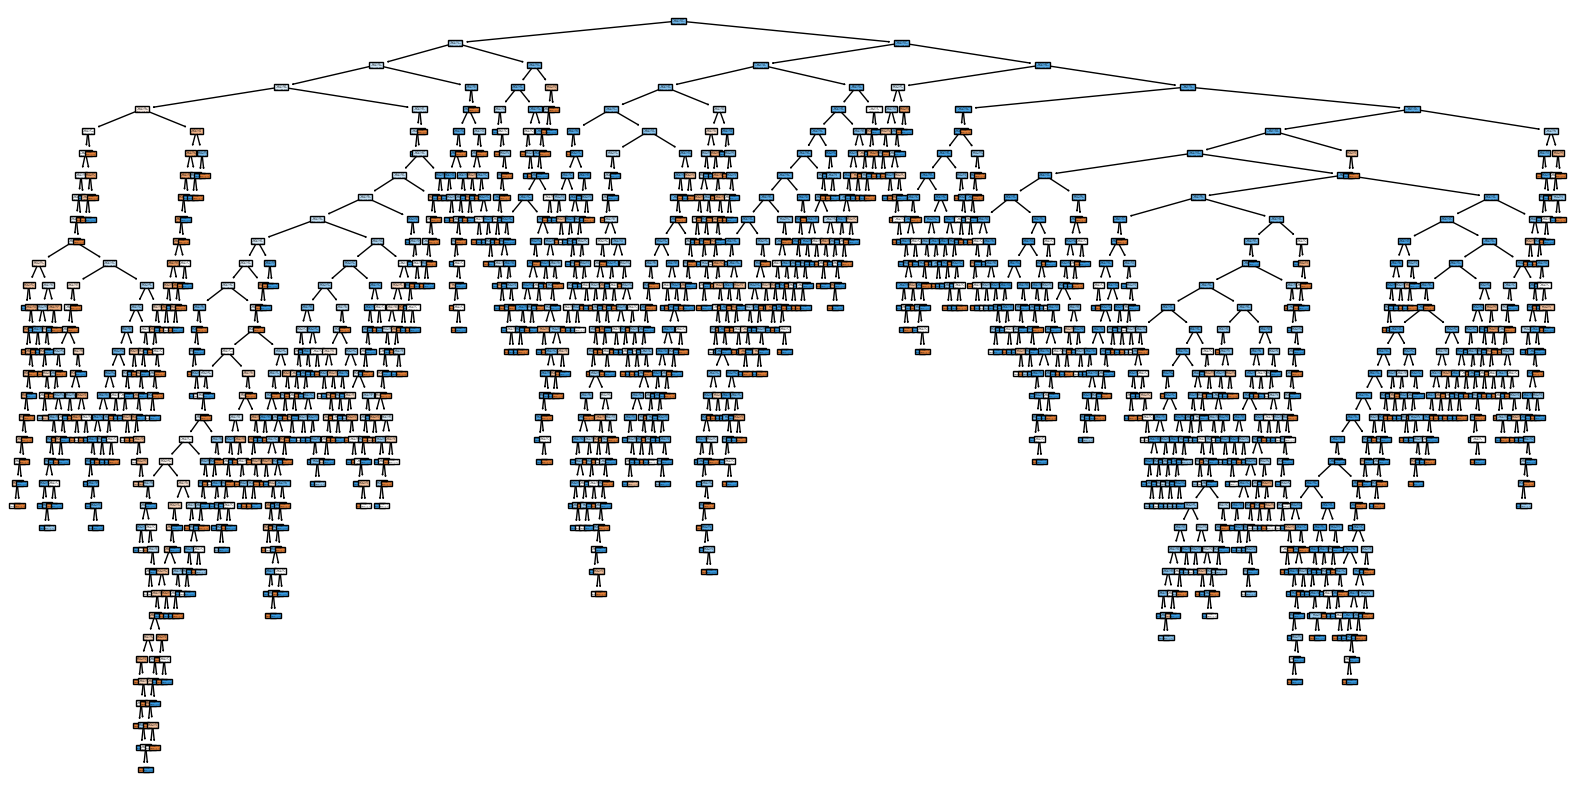

In [46]:
# Prepare the target variable
y_train = train_data['good_bad_flag'].map({'Good': 1, 'Bad': 0})


# Train the Decision Tree model
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

# Plot the Decision Tree


plt.figure(figsize=(20, 10))
plot_tree(dt, filled=True)
plt.show()

In [54]:

# Make predictions on the test data
y_pred_dt = dt.predict(X_test) 
print (y_pred_dt)

[1 1 1 ... 1 1 0]


In [56]:
# Save predictions to a CSV file
predictions = pd.DataFrame({'customerid': test_data['customerid'], 'predicted_good_bad_flag': y_pred_dt})
predictions['predicted_good_bad_flag'] = predictions['predicted_good_bad_flag'].map({1: 'Good', 0: 'Bad'})
predictions.to_csv('predictions.csv', index=False)